In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[9.3358e-01, 2.8762e-05, 8.9810e-03, 3.8155e-09, 4.1024e-12, 7.9585e-08,
          1.0978e-10, 1.2236e-11, 1.3723e-07, 5.7414e-02]]),
 tensor([[0.4509, 0.0565, 0.1781, 0.0095, 0.0024, 0.0174, 0.0047, 0.0030, 0.0194,
          0.2582]]),
 tensor([[0.2822, 0.0999, 0.1773, 0.0409, 0.0206, 0.0554, 0.0287, 0.0230, 0.0585,
          0.2135]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

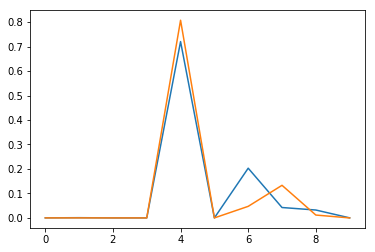

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
#export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model
    Runs but doesn't reproduce paper results; values are off and display strong changes between benchmarks
    Includes option to randomise params per batch, but results in worse performance'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)  #  Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = to_shape(self.wrapper.y_pred[self.b_mask])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1]
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init

In [15]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie0.h5'),EarlyStopping(10)])

1: Train=371.1374285888672 Valid=352.82728271484376
2: Train=338.72254455566406 Valid=338.9776531982422
3: Train=331.0331591796875 Valid=332.5016442871094
4: Train=325.8859602355957 Valid=327.01042541503904
5: Train=321.22441497802737 Valid=322.8598876953125
6: Train=316.6654769897461 Valid=319.5791381835937
7: Train=314.80758926391604 Valid=315.896552734375
8: Train=311.1687074279785 Valid=313.3478387451172
9: Train=308.8632495117188 Valid=310.05946350097656
10: Train=305.5046923828125 Valid=307.09462585449216
11: Train=301.39505020141604 Valid=304.4756884765625
12: Train=299.7280326843262 Valid=302.3311749267578
13: Train=296.9112178039551 Valid=299.6979821777344
14: Train=294.4155717468262 Valid=297.5619165039063
15: Train=291.77662704467775 Valid=295.2424725341797
16: Train=289.9382073974609 Valid=293.75446258544923
17: Train=287.62801193237306 Valid=291.9774368286133
18: Train=286.0225161743164 Valid=290.1485266113281
19: Train=283.8899853515625 Valid=288.503798828125
20: Train=28

In [17]:
model.save('weights/Inferno_Test_exact_bm0.h5')

In [18]:
model.load('weights/Inferno_Test_exact_bm0.h5')

# Results

In [19]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [20]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [21]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,9,1.0
1,5,1.0
2,7,1.0
3,7,1.0
4,8,1.0


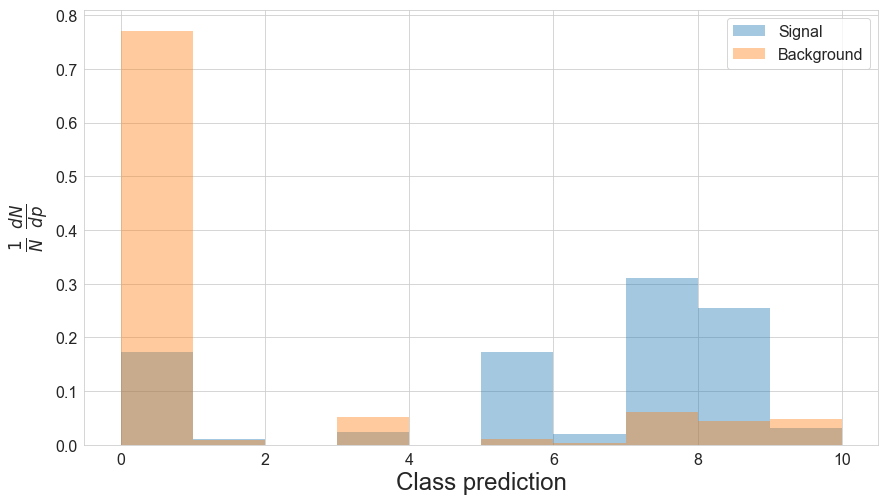

In [22]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [23]:
bin_preds(df)

In [24]:
df.head()

,pred,gen_target,pred_bin
0,9,1.0,9
1,5,1.0,5
2,7,1.0,7
3,7,1.0,7
4,8,1.0,8


In [25]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [26]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [27]:
f_s, f_b

(tensor([1.7299e-01, 1.1256e-02, 2.0000e-13, 2.4748e-02, 2.0000e-13, 1.7364e-01,
         2.0168e-02, 3.1104e-01, 2.5461e-01, 3.1544e-02]),
 tensor([7.7141e-01, 8.6480e-03, 2.0000e-13, 5.1470e-02, 2.0000e-13, 1.1540e-02,
         3.1340e-03, 6.1680e-02, 4.3568e-02, 4.8546e-02]))

In [28]:
asimov = (50*f_s)+(1000*f_b)

In [29]:
asimov, asimov.sum()

(tensor([7.8006e+02, 9.2108e+00, 2.1000e-10, 5.2707e+01, 2.1000e-10, 2.0222e+01,
         4.1424e+00, 7.7232e+01, 5.6299e+01, 5.0123e+01]), tensor(1050.0001))

In [30]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.25841904, 24.11259079, 23.97231865, 23.83837128, 23.71066666,
       23.58767891, 23.47084427, 23.35943413, 23.25399399, 23.1534214 ,
       23.05821228, 22.9681282 , 22.88420486, 22.80440712, 22.72955704,
       22.66064453, 22.59560585, 22.5359211 , 22.48086929, 22.43105125,
       22.38540459, 22.34425926, 22.30811501, 22.27591133, 22.2481575 ,
       22.22520065, 22.20604706, 22.19161797, 22.18087006, 22.17525864,
       22.17321777, 22.17520905, 22.18076515, 22.19117737, 22.205019  ,
       22.22273636, 22.24476242, 22.27051163, 22.29954529, 22.33280945,
       22.36963844, 22.41005325, 22.45358658, 22.50166512, 22.55225563,
       22.60725021, 22.66473007, 22.72701836, 22.7912426 , 22.8592186 ,
       22.93104172, 23.00603294, 23.08380127, 23.1652298 , 23.25031662,
       23.33758545, 23.42841911, 23.52228355, 23.61919975, 23.71916199,
       23.82203102])

In [31]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [32]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

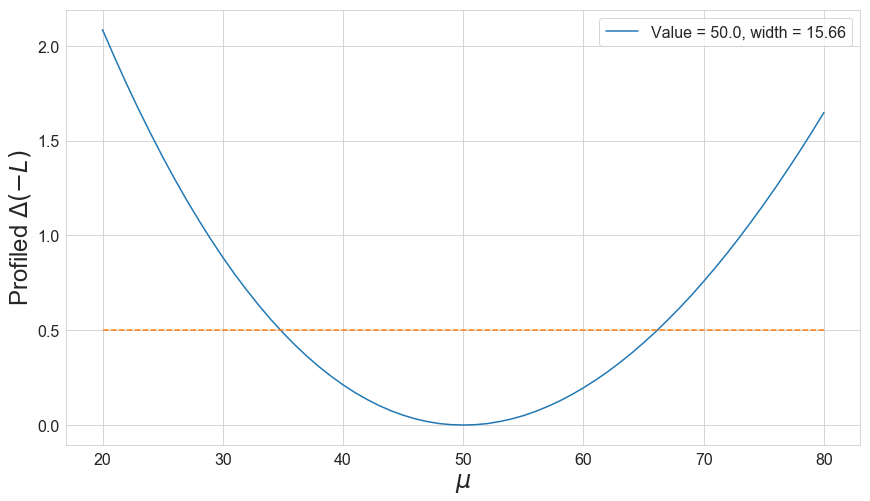

In [33]:
plot_likelihood(y-y.min())

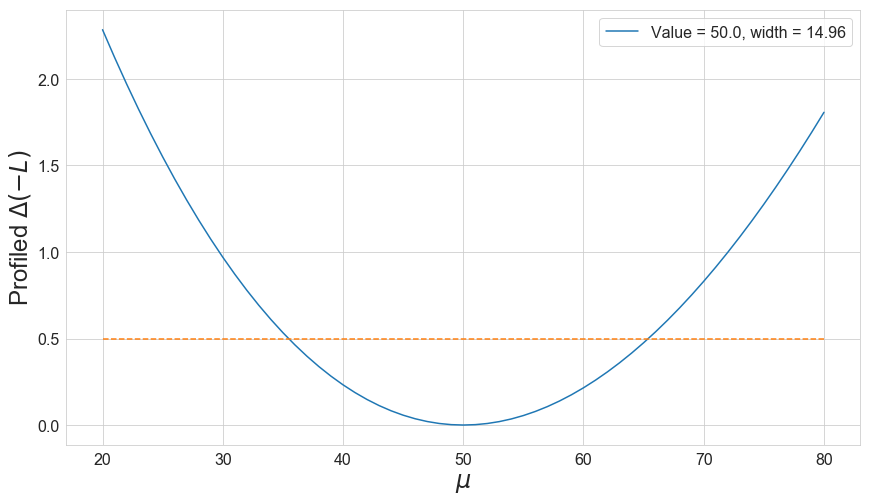

In [34]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [35]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [36]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [37]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,9,1.0,9,9,9,9,9,9,9,9,9,9,9
1,5,1.0,5,5,5,5,5,5,5,5,5,5,5
2,7,1.0,7,7,7,7,7,7,7,7,7,7,7
3,7,1.0,7,7,7,7,7,7,7,7,7,7,7
4,8,1.0,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999996,8,0.0,8,6,6,8,8,8,8,8,8,8,8
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,0,0.0,0,0,0,0,0,0,0,0,0,0,0


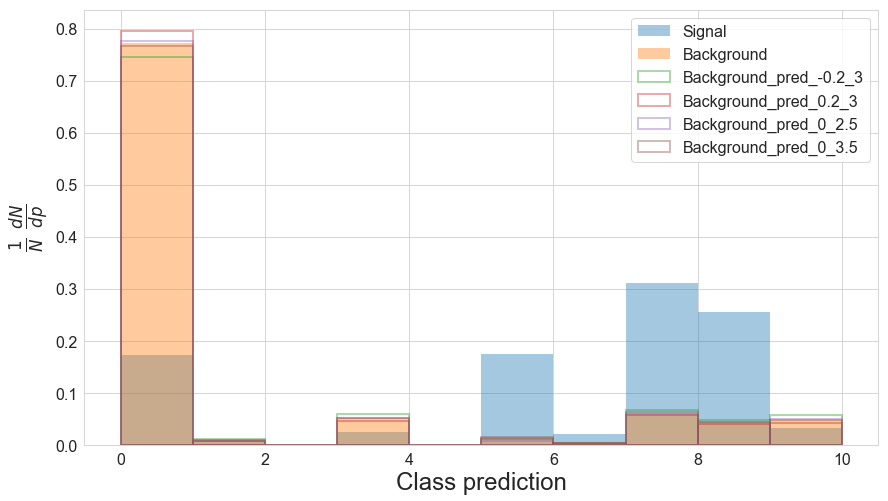

In [38]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([7.4898e-01, 1.1118e-02, 2.0000e-13, 5.9078e-02, 2.0000e-13, 8.9560e-03,
        2.3540e-03, 6.3992e-02, 4.7888e-02, 5.7630e-02])
tensor([7.4442e-01, 1.0558e-02, 2.0000e-13, 5.8364e-02, 2.0000e-13, 1.2578e-02,
        3.3320e-03, 6.6000e-02, 4.8116e-02, 5.6630e-02])
tensor([7.3955e-01, 1.0066e-02, 2.0000e-13, 5.7740e-02, 2.0000e-13, 1.6642e-02,
        4.4700e-03, 6.7714e-02, 4.8272e-02, 5.5550e-02])
tensor([7.7598e-01, 9.2080e-03, 2.0000e-13, 5.2184e-02, 2.0000e-13, 7.9180e-03,
        2.1560e-03, 5.9672e-02, 4.3340e-02, 4.9546e-02])
tensor([7.7141e-01, 8.6480e-03, 2.0000e-13, 5.1470e-02, 2.0000e-13, 1.1540e-02,
        3.1340e-03, 6.1680e-02, 4.3568e-02, 4.8546e-02])
tensor([7.6654e-01, 8.1560e-03, 2.0000e-13, 5.0846e-02, 2.0000e-13, 1.5604e-02,
        4.2720e-03, 6.3394e-02, 4.3724e-02, 4.7466e-02])
tensor([8.0056e-01, 7.5920e-03, 2.0000e-13, 4.5994e-02, 2.0000e-13, 6.8040e-03,
        2.0080e-03, 5.5398e-02, 3.8920e-02, 4.2722e-02])
tensor([7.9600e-01, 7.0320e-03, 2.0000e-1

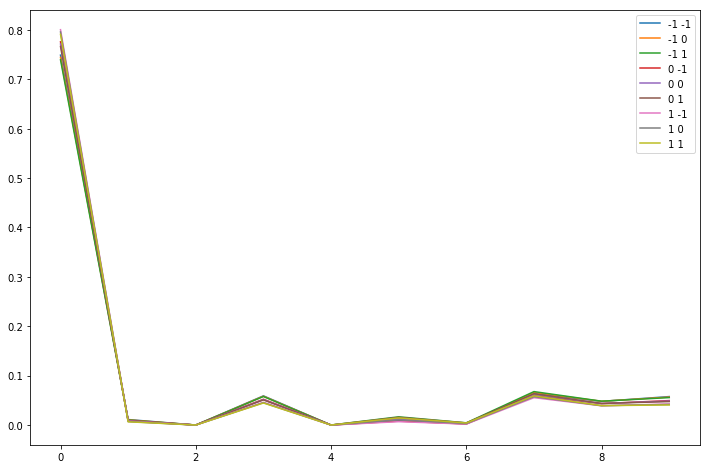

In [39]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [40]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [41]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [42]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [43]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [44]:
nll = to_np(nll)

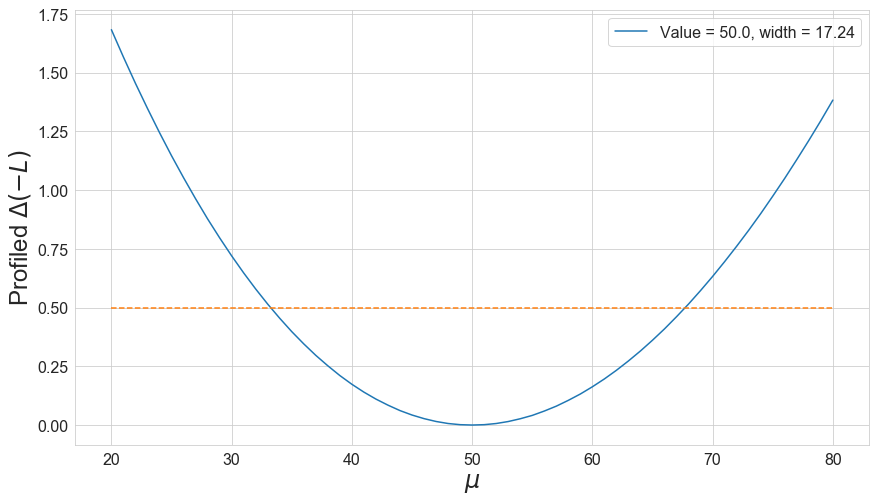

In [45]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [46]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [47]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.1183])
Linear regime: Mu 21.0, alpha tensor([1.0800])
Linear regime: Mu 22.0, alpha tensor([1.0417])
Linear regime: Mu 75.0, alpha tensor([-1.0094])
Linear regime: Mu 76.0, alpha tensor([-1.0487])
Linear regime: Mu 77.0, alpha tensor([-1.0879])
Linear regime: Mu 78.0, alpha tensor([-1.1270])
Linear regime: Mu 79.0, alpha tensor([-1.1661])
Linear regime: Mu 80.0, alpha tensor([-1.2050])


In [48]:
nll = to_np(nll)

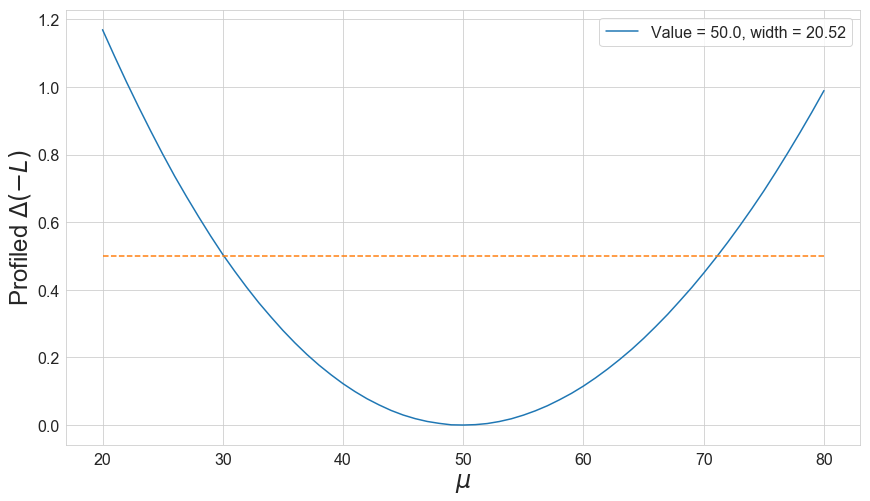

In [49]:
plot_likelihood(nll-nll.min())

## BM 2

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3612,  1.0585])
Linear regime: Mu 21.0, alpha tensor([-0.3490,  1.0221])
Linear regime: Mu 76.0, alpha tensor([ 0.3112, -1.0017])
Linear regime: Mu 77.0, alpha tensor([ 0.3233, -1.0348])
Linear regime: Mu 78.0, alpha tensor([ 0.3354, -1.0720])
Linear regime: Mu 79.0, alpha tensor([ 0.3474, -1.1091])
Linear regime: Mu 80.0, alpha tensor([ 0.3594, -1.1462])


In [51]:
nll = to_np(nll)

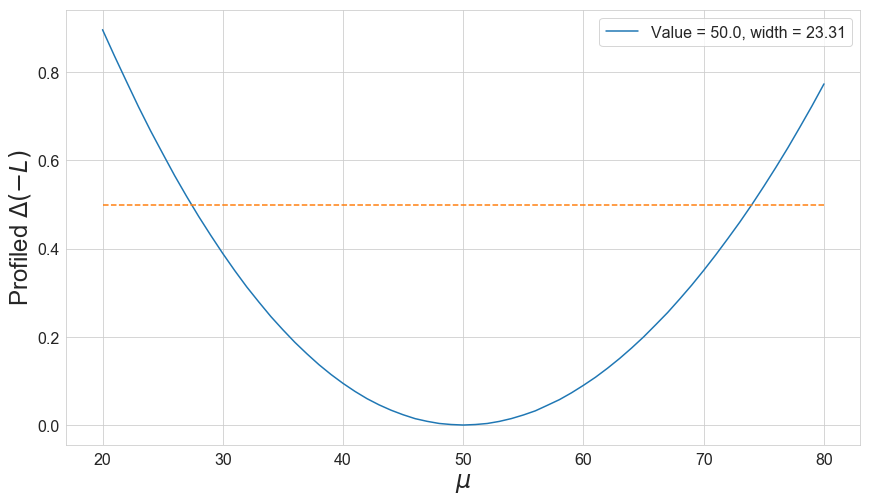

In [52]:
plot_likelihood(nll-nll.min())